In [2]:
!pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 96 kB 7.5 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [81]:
from duckduckgo_search import ddg_images
import matplotlib.pyplot as plt
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
import ipywidgets as widgets

In [89]:
keywords = ['Queen of Hearts','Alice']

In [90]:
def search_images(term, max_images = 20):
  print(f"Searching for '{term}'")
  return L(ddg_images(term,max_results = max_images)).itemgot('image')

In [91]:
def get_test_thumb(term, max_images = 1 ):
  term = str(term+" from Alice in Wonderland photo")
  urls = search_images(term,max_images=max_images)
  dest = str(term+".jpg")
  download_url(urls[0],dest, show_progress=False)
  im = Image.open(dest).to_thumb(256,256)
  plt.imshow(im)
  plt.show()

Searching for 'Queen of Hearts from Alice in Wonderland photo'


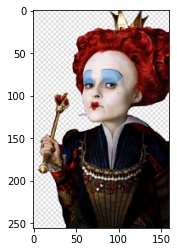

Searching for 'Alice from Alice in Wonderland photo'


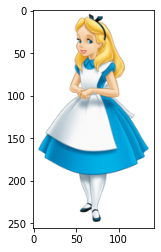

In [92]:
for keyword in keywords:
  get_test_thumb(keyword, max_images = 1 )

In [93]:
path = Path('Alice in Wonderland')
for _ in keywords:
  term = str(_+" from Alice in Wonderland photo")
  dest = (path/_)
  dest.mkdir(exist_ok = True, parents  = True)
  download_images(dest, urls = search_images(term))
  resize_images(path/_,max_size=400,dest=path/_)

Searching for 'Queen of Hearts from Alice in Wonderland photo'
Searching for 'Alice from Alice in Wonderland photo'


In [94]:
fns = get_image_files(path)
fns

(#106) [Path('Alice in Wonderland/Alice/c1f106ef-f7eb-42ff-9cac-714e5279c7ee.jpg'),Path('Alice in Wonderland/Alice/726bf1da-1788-4603-a261-71cb4ab9cf76.jpg'),Path('Alice in Wonderland/Alice/481b9d7c-cf5e-41a6-91f5-2492d63896fe.png'),Path('Alice in Wonderland/Alice/be69164e-e172-478d-9a7d-6beeba67cb45.jpg'),Path('Alice in Wonderland/Alice/alice_1.jpg'),Path('Alice in Wonderland/Alice/7b6c2500-ba5f-4e76-bc2d-8b1d367204dc.jpg'),Path('Alice in Wonderland/Alice/7a8660ec-8142-4d8b-a435-0da151edac5b.jpg'),Path('Alice in Wonderland/Alice/070c8e2b-3d3c-46bf-bafb-0a21e00bd38e.jpg'),Path('Alice in Wonderland/Alice/a56be0fb-a39c-49b1-99c3-a638e77fbe17.jpg'),Path('Alice in Wonderland/Alice/f8f6224d-ee3a-4b36-8d94-1e0f3e75390a.jpg')...]

In [95]:
failed = verify_images(fns)

In [96]:
failed

(#0) []

In [97]:
??verify_images

In [99]:
class DataLoader(GetAttr):
  def __init__(self,*loaders):
    self.loaders = loaders
  def __getitem__(self,i):
    self.loaders[i]
    train,valid = add_props(lambda i, self: self[i])

In [100]:
characters = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items =get_image_files,
    splitter= RandomSplitter(valid_pct=0.2, seed = 24),
    get_y = parent_label,
    item_tfms=Resize(128)
)

In [101]:
dls = characters.dataloaders(path)

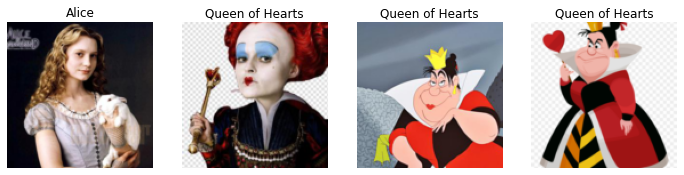

In [102]:
dls.valid.show_batch(max_n=4,nrows=1)

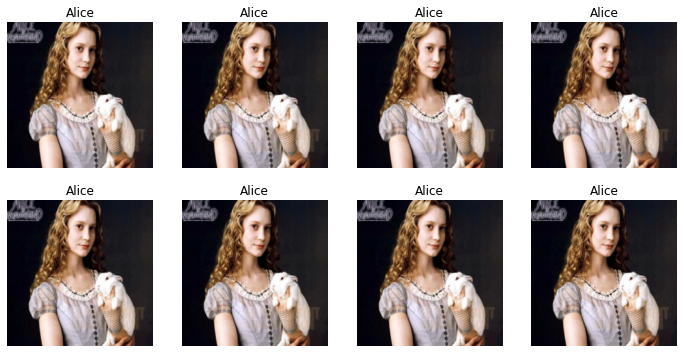

In [103]:
characters = characters.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms())
dls = characters.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

In [104]:
learn = cnn_learner(dls,resnet18, metrics = error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


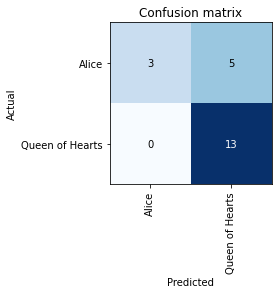

In [105]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

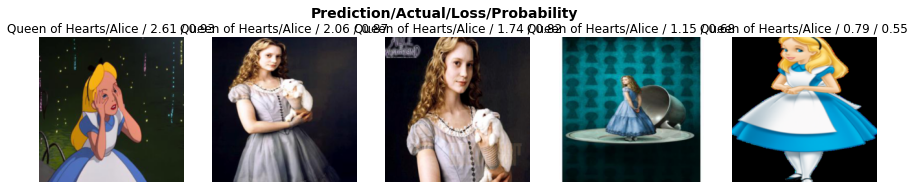

In [106]:
interp.plot_top_losses(5,nrows=1)

In [107]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [109]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

In [110]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [111]:
learn_inf = load_learner(path/'export.pkl')

In [112]:
learn_inf.predict('Alice in Wonderland/Queen of Hearts/queen.jpg')

('Queen of Hearts', TensorBase(1), TensorBase([0.0027, 0.9973]))

In [113]:
btn_upload = widgets.FileUpload()

In [114]:
btn_upload

FileUpload(value={}, description='Upload')

In [115]:
img = PILImage.create(btn_upload.data[-1])

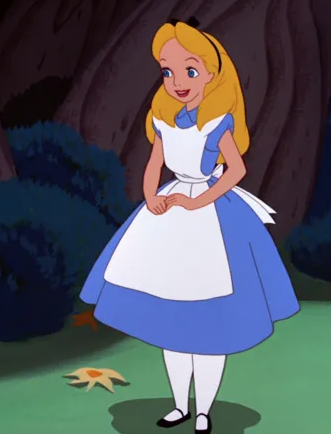

In [116]:
img

In [117]:
pred,pred_idx,probs = learn_inf.predict(img)

In [118]:
lbl_pred=widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.4f}'
lbl_pred

Label(value='Prediction: Alice; Probability: 0.9394')

In [119]:
btn_run = widgets.Button(decription='Classify')
btn_run

Button(style=ButtonStyle())

In [120]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [121]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.4f}'

In [122]:
VBox([widgets.Label('Select your character!'),btn_upload,btn_run,out_pl,lbl_pred])